# Régression linéaire simple & Multiple


On commence par l'importation des packages nécessaires

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, make_scorer


### Partie 01: Régression simple


Nous voulons trouver la droite qui approxime au mieux le nuage de points suivants

In [2]:
xs, ys = make_regression(n_samples=10, n_features=1, noise=3)     # Generate points cloud (10 points)
xs = xs[:, 0]

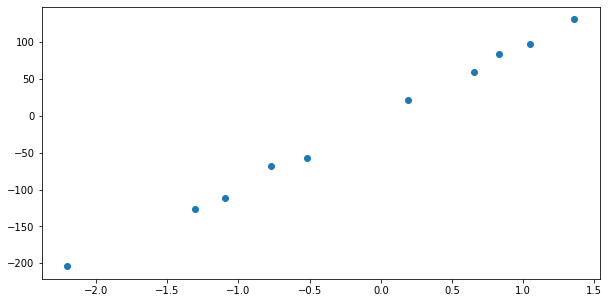

In [3]:
plt.figure(figsize=(10, 5))
plt.scatter(xs, ys)       # Plot generated points

##### Méthode 01: Approche analytique (MCO)

Nous cherchons à estimer a et b tels que:
$$ y = a.x + b $$
$$ a = cov(x, y) / var(x) $$
$$ b = \bar{y} - a.\bar{x} $$

a =  95.11373873866195
b =  -0.2283820038268516


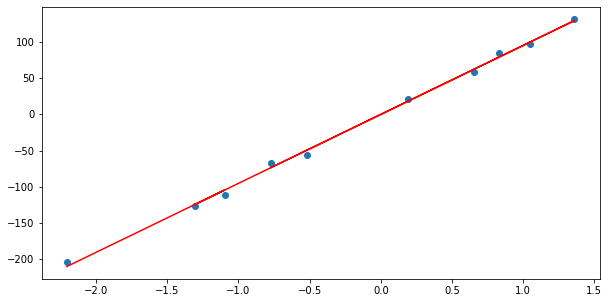

In [4]:
a = np.cov(xs, ys, bias=True)[0, 1] / np.var(xs)
b = ys.mean() - a * xs.mean()
 
print("a = ", a)
print("b = ", b)

ys_hat = [a * x + b for x in xs]

plt.figure(figsize=(10, 5))
plt.plot(xs, ys_hat, c='red')
plt.scatter(xs, ys)

##### Méthode 02: Descente de Gradient

Définissons d'abord les fonctions permettant d'effectuer une descente de gradient:

In [5]:
# This function computes the partial difference quotient for the i-th(x[i]) variable of f
def partial_difference_quotient(f, x, i, h=0.00001):
    x = np.array(x)
    x_new = np.array([x[j] + h if j == i else x[j] for j in range(len(x))])
    return (f(x_new) - f(x)) / h


# This function computes the gradient of f at a given point x
def gradient(f, x, h=0.00001):
    x = np.array(x)
    return np.array([partial_difference_quotient(f, x, i, h) for i in range(len(x))])

    
def gradient_step(f, x, grad_fn = None, alpha=0.0001):
    # If no standard gradient function is given for this function, compute it using gradient function (Computationnaly heavier)
    if grad_fn is None:
        grad_step = -1 * alpha * gradient(f, x)
    else:
        grad_step = -1 * alpha * grad_fn(x)
    new_x = x + grad_step
    return new_x

    
def gradient_descent(f, x, nb_steps=1000):
    new_x = x
    for i in range(nb_steps):
        x = new_x
        step_size = 0.01
        new_x = gradient_step(f, x, alpha=step_size)
    return new_x

Nous définissons maintenant la fonction squared error qui prend pour variables les coefficient de la droite, et nous effectuons une descente de gradient sur cette fonction pour trouver les bons coefficients, nous remarquent que les coefficients trouvés sont identiques à ceux de la méthode précédente.

a =  95.11373287665991
b =  -0.22838806502849704


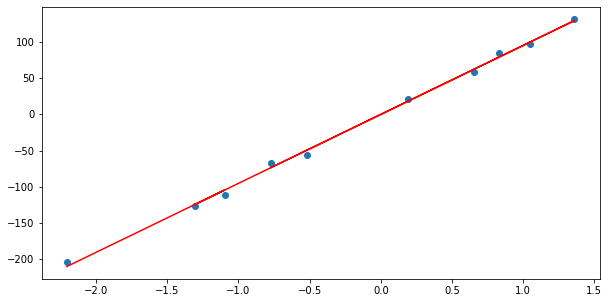

In [6]:
# Function to minimize (squared error)
def squared_error(beta):
    return np.sum( [ ( y_i - ( beta[0] * x_i + beta[1] ) ) ** 2 for x_i, y_i in zip(xs, ys) ] )


a, b = np.random.rand(2) * 100
a, b = gradient_descent(squared_error, [a, b], nb_steps=10000)

print("a = ", a)
print("b = ", b)

ys_hat = [a * x + b for x in xs]

plt.figure(figsize=(10, 5))
plt.plot(xs, ys_hat, c='red')
plt.scatter(xs, ys)

Nous effectuons une dernière vérification avec la fonction de régression linéaire définie sur scikit learn et nous remarquons que les coefficients sont identiques aussi:

In [7]:
reg = LinearRegression()
reg.fit(xs.reshape(-1, 1), ys)

print("a = ", reg.coef_[0])
print("b = ", reg.intercept_)

a =  95.11373873866191
b =  -0.2283820038268587


### Partie 02: Régression multiple

In [8]:
# Génerer un nuages de points (10 points)
xs, ys = make_regression(n_samples=10, n_features=4, noise=3)
xs = np.c_[np.ones(len(xs)), xs]

##### Méthode 01: Approche analytique (MCO)

In [9]:
beta = np.linalg.inv(xs.T @ xs) @ xs.T @ ys
print("beta = ", beta)

beta =  [ 1.41961149 71.00775502 79.18724125 78.01422147 22.51546013]


##### Méthode 02: Descente de Gradient

In [10]:
def error(beta):
    return (ys - xs @ beta).T @ (ys - xs @ beta)

In [11]:
beta = np.random.rand(len(xs[0])) * 100
beta = gradient_descent(error, beta, nb_steps=1000)
print("beta = ", beta)

beta =  [ 1.3961077  70.87924228 79.15489543 77.98820479 22.47705437]


Confirmation avec scikit:

In [12]:
reg = LinearRegression()
reg.fit(xs, ys)

beta = np.hstack([reg.intercept_, reg.coef_[1:]])

print("beta = ", beta)

beta =  [ 1.41961149 71.00775502 79.18724125 78.01422147 22.51546013]


### Passage à la réalité

In [125]:
# Read the dataset
df = pd.read_csv("car prices\carprices.csv", sep=r',', skipinitialspace=True)

# These are categorical variables
# df["symboling"] = df["symboling"].astype("str")
df["car_ID"] = df["car_ID"].astype("str")

# Only keep the company name, as the model names may make it too complicated, also correct typos
df["company_name"] = df["CarName"].apply(lambda x: x.split()[0].lower())
df["company_name"] = df["company_name"].apply(lambda x:
                                              "volkswagen" if x in ["volkswagen", "vokswagen", "vw"]
                                              else "porsche" if x in ["porcshce", "porsche"]
                                              else "mazda" if x in ["mazda", "maxda"]
                                              else "toyota" if x in ["toyota", "toyouta"]
                                              else "ford" if x in ["mercury"]
                                              else x)

# Now extract country name of each brand in order to reduce cardinality
df["company_country"] = df["company_name"].apply(lambda x:
                                                 "germany" if x in ['audi', 'bmw', 'porsche', 'volkswagen']
                                                 else "usa" if x in ['chevrolet', 'dodge', 'buick', 'ford', 'plymouth']
                                                 else "japan" if x in ['honda', 'isuzu', 'mazda', 'mitsubishi', 'nissan', 'subaru', 'toyota']
                                                 else "france" if x in ['peugeot', 'renault']
                                                 else "sweden" if x in ['volvo', 'saab']
                                                #  else "uk" if x in ['jaguar']
                                                #  else "italy" if x in ['alfa-romero']
                                                 else "other")

# Change the categorical variables that can be numbers
df["doornumber"] = df["doornumber"].apply(lambda x:
                                          2 if x == 'two' else 4 if x == 'four' else x)

df['cylindernumber'] = df['cylindernumber'].apply(lambda x:
                                                  2 if x == 'two' 
                                                  else 3 if x == 'three'
                                                  else 4 if x == 'four' 
                                                  else 5 if x == 'five' 
                                                  else 6 if x == 'six' 
                                                  else 8 if x == 'eight'
                                                  else 12 if x == 'twelve' 
                                                  else x)

df['gas'] = df['fueltype'].apply(lambda x:
                                 1 if x == 'gas' 
                                 else 0 if x == 'diesel' 
                                 else x)

df['engine_front'] = df['enginelocation'].apply(lambda x:
                                                1 if x == 'front'
                                                else 0 if x == 'rear'
                                                else x)

df['aspiration_standard'] = df['aspiration'].apply(lambda x:
                                                1 if x == 'std'
                                                else 0 if x == 'turbo'
                                                else x)

# Drop irrelevant columns
df.drop(["CarName", "car_ID", "fueltype", "aspiration", "company_name",
        "enginelocation"], axis=1, inplace=True)

# Get the numerica, categorical, and target columns
cols = df.columns
cat_cols = [col for col in cols if df[col].dtype == "object"]
num_cols = [col for col in cols if col not in cat_cols and col != "price"]
target_col = 'price'

# Drop categorical columns with too big cardinality
card_th = 10
cols_to_drop = [col for col in cat_cols if df[col].nunique() > card_th]
df = df.drop(cols_to_drop, axis='columns', errors='ignore')

# Renew column types
cols = df.columns
cat_cols = [col for col in cols if df[col].dtype == "object"]
num_cols = [col for col in cols if col not in cat_cols and col != "price"]
target_col = 'price'

# Apply a standard scaler to the numerical data before doing a PCA (to rightly catch the variance along all the variables)
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# After investigation, we can conclude that around 7 principal components is enough to represent our numerical data
nb_components_to_keep = 10
pc_to_keep = ['PC_' + str(i+1) for i in range(nb_components_to_keep)]
pca = PCA(n_components=nb_components_to_keep)
df[pc_to_keep] = pca.fit_transform(df[num_cols])

# We apply a One Hot Encoding to the categorical variables
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
ohe.fit(df[cat_cols])
ohe_cols = list(ohe.get_feature_names_out())
df[ohe_cols] = ohe.transform(df[cat_cols])

# We can now get rid of the numerical columns as we represent them with the principal components
df.drop(num_cols, axis='columns', inplace=True)
# We can also get rid of the categorical columns as we represent them with the one hot encoded columns
df.drop(cat_cols, axis='columns', inplace=True)

# Renew column types
cols = df.columns
cat_cols = [col for col in cols if df[col].dtype == "object"]
num_cols = [col for col in cols if col not in cat_cols and col != "price"]
target_col = 'price'

# Reorder the columns for a better view
df = df[num_cols + cat_cols + [target_col]]

df.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,company_country_france,company_country_germany,company_country_japan,company_country_other,company_country_sweden,company_country_usa,price
0,-1.188991,2.557813,0.944100,0.487235,-0.895975,-2.126462,0.254183,0.037402,0.866759,-1.015897,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,13495.0
1,-1.188991,2.557813,0.944100,0.487235,-0.895975,-2.126462,0.254183,0.037402,0.866759,-1.015897,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,16500.0
2,0.381595,1.745192,0.859004,0.106874,2.128795,0.458073,1.038397,-0.179913,-1.346996,-0.643977,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,16500.0
3,-0.384611,0.201121,-0.522797,-0.592737,0.076045,0.762925,-0.091027,0.970511,0.058262,-0.934040,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,13950.0
4,1.086932,1.164683,-0.604279,-0.547080,0.417359,0.745913,0.184035,0.772124,-0.297433,-1.376087,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,17450.0


In [157]:
X = df.drop(target_col, axis='columns')
y = df[target_col]

reg = LinearRegression()

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, train_size=0.8, test_size=0.2
)

reg.fit(X_train, y_train)

preds = reg.predict(X_valid)

error = r2_score(preds, y_valid)

print('r2 =', error)

print("")
print("Sample pred/real:")
print("-----------------")

titles = ["Preds", "Real", "Diff"]

# Draw a sample to view the difference
sample_size = 8
sample_start = np.random.randint(0, len(preds) - sample_size)
sample_end = sample_start + sample_size

table_data = [np.round(preds[sample_start:sample_end]), np.round(y_valid[sample_start:sample_end]), 
              np.round(preds[sample_start:sample_end] - y_valid[sample_start:sample_end])]

for title, row in zip(titles, table_data):
    print(title + ":\t", end="")
    print(" ".join(["{: >10}" for _ in range(len(row))]).format(*row))



r2 = 0.8775722387124794

Sample pred/real:
-----------------
Preds:	    8965.0     4933.0    13540.0     5292.0    15249.0     5591.0     4318.0    30602.0    17242.0    17307.0     5459.0    37685.0
Real:	    9279.0     6918.0    16430.0     6695.0    12964.0     6338.0     6488.0    36880.0    18950.0    15985.0     7898.0    37028.0
Diff:	    -314.0    -1985.0    -2890.0    -1403.0     2285.0     -747.0    -2170.0    -6278.0    -1708.0     1322.0    -2439.0      657.0
